## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_andrinas_edit as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_andrinas_edit' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_andrinas_edit.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6, 0.55, 0.94, -2.50])
upper = np.array([0.1275, 0.024, 1.1, 0.90, 1.00, -0.33])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76, 0.69, 0.9655, -1])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_andrinas_edit' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_andrinas_edit.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

In [9]:
N_countsSimulator.N_counts

array([1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04,
       5.88511940e+04, 2.53148842e+03, 6.50855639e+03, 6.79903632e+03,
       4.77688556e+03, 2.60820123e+03, 1.41327071e+02, 2.40973371e+02,
       1.54407289e+02, 6.19683804e+01, 1.80223466e+01, 1.15793270e+00,
       8.97133179e-01, 2.22000351e-01, 2.95440371e-02, 2.45071739e-03])

In [10]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [11]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

0.75142584 s


array([ 5389.8009519 , 17168.74753011, 23234.67350825, 22065.05215602,
       16962.2080584 ,  5199.23461887, 16423.75731783, 22039.68694332,
       20757.06955939, 15827.82735363,  5010.0648901 , 15694.20633604,
       20883.97079553, 19506.37417823, 14754.38904041,  4822.61905025,
       14980.95029623, 19767.90723047, 18312.09111024, 13739.90025308])

## HMF plot

In [12]:
masses = np.logspace(14, 16, num = 10)
z = np.array([0.0])
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
hmc = N_countsSimulator.halo_mass_function(cosmo_ccl, masses, z)

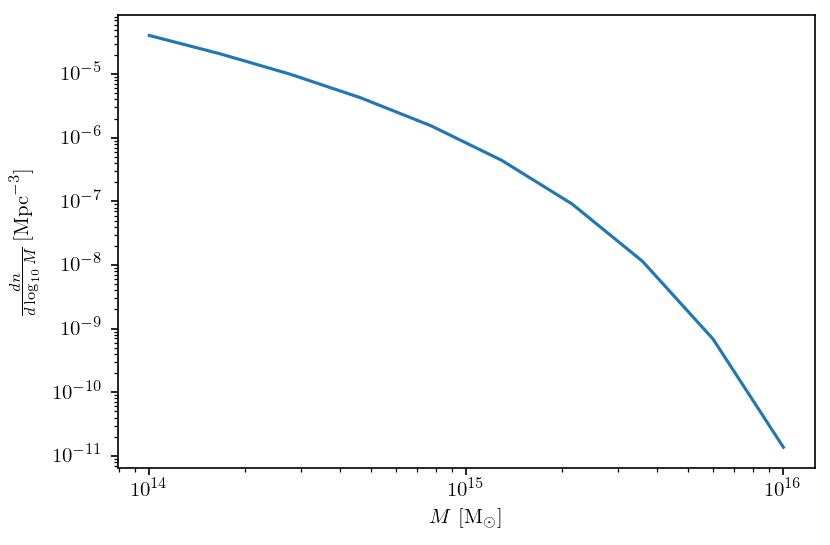

In [13]:
plt.figure()
plt.ylabel(r'$\frac{dn}{d\log_{10}M}\,[{\rm Mpc}^{-3}]$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(masses, hmc[0,:], c=color_map(0))

## For 1 mass bin (14 to 14.5)

In [14]:
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)

In [15]:
log10masses = np.linspace(14., 14.5, num = 2)
z_min = np.array([0.1])
z_max = np.array([0.2])

n_steps_masses = 1000
n_steps_z = 100

log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [16]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

0.28879119499999995 s


array([17787.26407648])

## For 2 mass bins (14 to 14.5 and 14.5 to 15) and the same redshift bin

In [17]:
log10masses = np.linspace(14., 15, num = 3)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [18]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

0.31196843200000046 s


array([10526.03322217,  9784.6584691 ])

## Set up simulator

In [ ]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [ ]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [ ]:
N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data

## Define ensemble of NDEs

In [ ]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=20, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [ ]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}', 'h', 'n_{s}', 'w_{0}'],
                            results_dir = "simulators/mass_function_n_counts/results/")

## Sequential Neural Likelihood

In [ ]:
n_initial = 5 
n_batch = 5 
n_populations = 10 

In [ ]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

## Sample the learned posterior

In [ ]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])